Import Data:

In [81]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', 999)
import pandas.io.sql as psql
# plot a figure directly on Notebook
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /Users/kobo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
from os.path import exists
data_dir = '/Users/kobo/Documents/aiforhealth/AIForHealth_V-A/data/mimic-iii-clinical-database-1.4'

In [83]:
admissions = pd.read_csv(f'{data_dir}/ADMISSIONS.csv.gz', compression='gzip', low_memory=False)
note_events = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')
patients = pd.read_csv(f'{data_dir}/PATIENTS.csv')

# admissions = pd.read_csv("demo-data/ADMISSIONS.csv")
# diagnoses = pd.read_csv("demo-data/DIAGNOSES_ICD.csv")
# patients = pd.read_csv("demo-data/PATIENTS.csv")

print("Admissions Table\t" + str(admissions.shape))
print(admissions.columns)
# print("\nDiagnoses Table\t\t" + str(diagnoses.shape))
# print(diagnoses.columns)
print("\nPatients Table\t\t" + str(patients.shape))
print(patients.columns)
print("\nNote Events Table\t\t" + str(note_events.shape))
print(note_events.columns)

/var/folders/8g/mc6q7d1x28n5v1v_c5nv73cw0000gn/T/ipykernel_97006/151477038.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  note_events = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')


Admissions Table	(58976, 19)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

Patients Table		(46520, 8)
Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

Note Events Table		(2083180, 11)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')


In [106]:
# Merge Tables
# merged = admissions.merge(patients, on="SUBJECT_ID").merge(diagnoses, 
#             left_on=["SUBJECT_ID","HADM_ID"], right_on=["SUBJECT_ID","HADM_ID"])
merged = admissions

#
# PROBLEM: there are multiple entries now for one admission time, each entry represents a different diagnoses
    # Counts for diagnoses for one admittime range from 1 to 57
        # print(merged['ADMITTIME'].value_counts())
# Possible Fixes: merge them all together and make a new column that holds each diagnoses in an array

# Convert time to objects
merged["ADMITTIME"] = pd.to_datetime(merged["ADMITTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DISCHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DEATHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged = merged.reset_index(drop = True)

merged['NEXT_ADMITTIME'] = merged.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
merged['NEXT_ADMISSION_TYPE'] = merged.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [107]:
len(merged['NEXT_ADMITTIME'].unique())

12451

In [108]:
rows = merged.NEXT_ADMISSION_TYPE == 'ELECTIVE'
merged.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
merged.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
len(merged['NEXT_ADMITTIME'].unique())

11048

In [109]:
merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = merged.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [110]:
merged['NEXT_ADMITTIME'].unique()

<DatetimeArray>
[                'NaT', '2135-05-09 14:11:00', '2135-01-30 20:50:00',
 '2157-10-18 19:34:00', '2191-02-23 05:23:00', '2131-05-12 19:49:00',
 '2119-01-04 18:12:00', '2157-12-02 00:45:00', '2174-01-04 22:21:00',
 '2196-04-14 04:02:00',
 ...
 '2191-08-03 19:11:00', '2191-12-23 01:03:00', '2133-08-01 19:20:00',
 '2125-11-01 00:00:00', '2197-06-16 03:01:00', '2197-07-03 02:24:00',
 '2182-07-03 19:50:00', '2201-05-15 13:12:00', '2157-01-05 17:27:00',
 '2157-02-16 17:31:00']
Length: 11048, dtype: datetime64[ns]

In [111]:
merged['DAYS_NEXT_ADMIT']=(merged.NEXT_ADMITTIME - merged.DISCHTIME).dt.total_seconds()/(24*60*60)
merged['DAYS_STAY'] = (merged.DISCHTIME - merged.ADMITTIME).dt.total_seconds()/(24*60*60)
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750


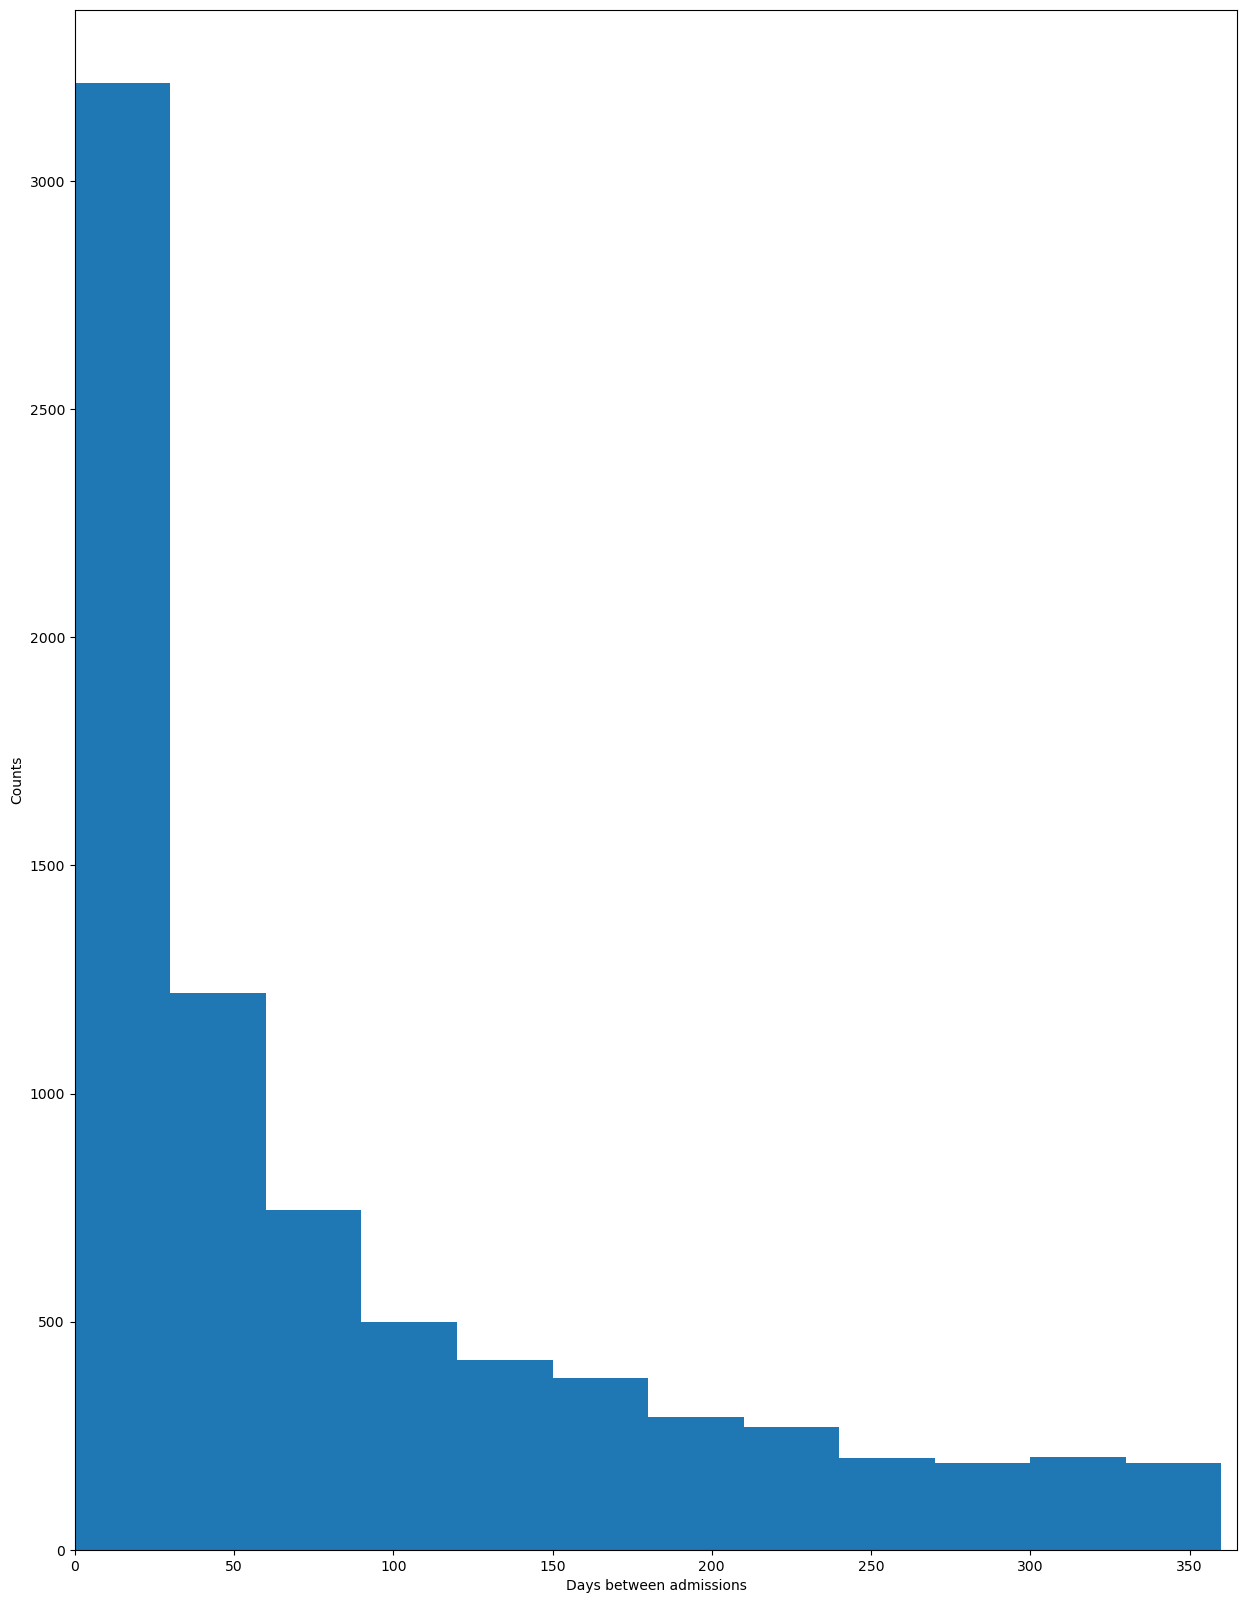

In [112]:
plt.hist(merged.loc[~merged.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [113]:
# For all 'CATEGORY' = 'Discharge summary':
    #'DESCRIPTION': ['Addendum', 'Report']        *Do we care if Addendum vs. Report? Addendum seems to have more information than initial Report but also some different info like Service:"" 
    #'CGID': NaN
    #'ISERROR': NaN
    
# could use all categories of notes by concatenating them if we wanted.

discharge_notes = note_events[note_events['CATEGORY']=='Discharge summary']
unique_discharge_notes = discharge_notes.groupby(['SUBJECT_ID','HADM_ID']).nth(-1).reset_index()
unique_discharge_notes.duplicated(['HADM_ID']).sum() == 0

True

In [114]:
merged = merged.merge(unique_discharge_notes[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [115]:
merged = merged.merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on=['SUBJECT_ID'], how='left')

In [116]:
#Calculate age

merged['DOB'] = pd.to_datetime(merged["DOB"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged['ADMITTIME'] = pd.to_datetime(merged['ADMITTIME'])
merged['DOB']
merged['AGE'] = ((merged['ADMITTIME'].values  - merged['DOB'].values).astype(int)/8.64e13//365).astype(int)


In [117]:
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY,TEXT,DOB,GENDER,AGE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889,NaN,2138-07-17,M,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722,Admission Date: [**2101-10-20**] Discharg...,2025-04-11,M,76
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028,Admission Date: [**2191-3-16**] Discharge...,2143-05-12,F,47
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222,NaN,2103-02-02,M,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583,Admission Date: [**2175-5-30**] Dischar...,2109-06-21,F,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833,Admission Date: [**2181-1-27**] ...,2127-04-08,M,53
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250,Admission Date: [**2184-12-24**] ...,2137-04-07,M,47
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139,Admission Date: [**2144-7-25**] ...,2078-10-17,F,65
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750,Admission Date: [**2147-2-8**] D...,2058-05-29,F,88


In [118]:
print(merged.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size())
merged[merged['ADMISSION_TYPE'] != 'NEWBORN'].groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64


ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN           NaN
URGENT       0.042665
dtype: float64

In [119]:
merged = merged[merged['ADMISSION_TYPE'] != 'NEWBORN']

In [120]:
pd.to_numeric(df['ROW_ID'], errors='coerce')
df[pd.to_numeric(df['ROW_ID'], errors='coerce').isna()]['ROW_ID']

Series([], Name: ROW_ID, dtype: int64)

In [121]:
merged['READMISSION'] = (merged.DAYS_NEXT_ADMIT < 30).astype('int')
merged['READMISSION'].value_counts()

/var/folders/8g/mc6q7d1x28n5v1v_c5nv73cw0000gn/T/ipykernel_97006/331978591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['READMISSION'] = (merged.DAYS_NEXT_ADMIT < 30).astype('int')


READMISSION
0    48109
1     3004
Name: count, dtype: int64

In [122]:
shuffled_merged = merged.sample(n = len(merged), random_state = 42)
shuffled_merged = shuffled_merged.reset_index(drop = True)

# Save 30% of the data as validation and test data 
valid_and_test_data = merged.sample(frac=0.30,random_state=42)
test_data = valid_and_test_data.sample(frac = 0.5, random_state = 42)
valid_data = valid_and_test_data.drop(test_data.index)

# use the rest of the data as training data
train_data = shuffled_merged.drop(valid_and_test_data.index)

print(merged.shape)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)
print(str(test_data.shape[0] + valid_data.shape[0] + train_data.shape[0]))

KeyError: '[53583, 53469, 58611, 53749, 56860, 51728, 55207, 56347, 56648, 57524, 58474, 51553, 54260, 51593, 52844, 58392, 54073, 58080, 55410, 54309, 55294, 53654, 54212, 51931, 53549, 53503, 57500, 57266, 58817, 51946, 53538, 56102, 54395, 52139, 56889, 53609, 56566, 58262, 54630, 58038, 57849, 55400, 57070, 54833, 58911, 53001, 57242, 51285, 56061, 51499, 57087, 51564, 52112, 58140, 53658, 55744, 55348, 54418, 58709, 57918, 54263, 55043, 58542, 56697, 55214, 51496, 52843, 54573, 56819, 54108, 57032, 52352, 56307, 57218, 54288, 55972, 57733, 51184, 52948, 54369, 52657, 53063, 54230, 57762, 53572, 53178, 56759, 57750, 55572, 53334, 51583, 51557, 58195, 53460, 55504, 58060, 53416, 58427, 58692, 57868, 52227, 56691, 53809, 58311, 51551, 52782, 52519, 53345, 57125, 54221, 54801, 57387, 53822, 55964, 54332, 58122, 55345, 56804, 57927, 51169, 52581, 56785, 57048, 56573, 56642, 58178, 57190, 58480, 53642, 53040, 55287, 51795, 58958, 58872, 56508, 58943, 54092, 53593, 58320, 56521, 54002, 55743, 52910, 57981, 57165, 51940, 54107, 54185, 57628, 55203, 51582, 53456, 56323, 54456, 58089, 57503, 57737, 56676, 52966, 54938, 55227, 53246, 58596, 57061, 52916, 55769, 51479, 56755, 57187, 57124, 52306, 58131, 58317, 53627, 53704, 56164, 53084, 57384, 54435, 57902, 57423, 52181, 54657, 53055, 57409, 57059, 58833, 57072, 56750, 58618, 55772, 56189, 52206, 57978, 57758, 56089, 52050, 53602, 57840, 55016, 55946, 55553, 53594, 53217, 54346, 58291, 52414, 58175, 55623, 58913, 52552, 51546, 57578, 51308, 52798, 54517, 54506, 57131, 58331, 53971, 53578, 57931, 57759, 52348, 57103, 52461, 56130, 53307, 54341, 51882, 56312, 58776, 51532, 57359, 55584, 54451, 57237, 55298, 55859, 52642, 56451, 56612, 51721, 52922, 54993, 55271, 51302, 53512, 55852, 55452, 53703, 57372, 52562, 52626, 56315, 52877, 56140, 53957, 57933, 55288, 55349, 51852, 56597, 52433, 51986, 54832, 54616, 51805, 55910, 56324, 56775, 55261, 51592, 51600, 54955, 55818, 55495, 57147, 57249, 56306, 57851, 58457, 55860, 52170, 53335, 55632, 57000, 54730, 54810, 58211, 52797, 52559, 54536, 56522, 55041, 54357, 51713, 54117, 56069, 53091, 53579, 51178, 56082, 52064, 57255, 57601, 55790, 53015, 52849, 56337, 56435, 51590, 53808, 56732, 55879, 52747, 53497, 53073, 56735, 58277, 58273, 53354, 51467, 53187, 51248, 56025, 52708, 57285, 57572, 51397, 58411, 55796, 57855, 55038, 54906, 56238, 56518, 56221, 57812, 58800, 57290, 52478, 54067, 52395, 56411, 54132, 55912, 54763, 53968, 53711, 56408, 51201, 57356, 57881, 57332, 52471, 56023, 54061, 54472, 53476, 58710, 52532, 55079, 51510, 56039, 53496, 55070, 55011, 52158, 51796, 56665, 54041, 54200, 54315, 55034, 53441, 52715, 56686, 52653, 57582, 58888, 57661, 58437, 55821, 52817, 51190, 56760, 53846, 53719, 53070, 58697, 55311, 53435, 58601, 57465, 56727, 58506, 52378, 57436, 51176, 57053, 51866, 52949, 58655, 51330, 51732, 53671, 55326, 53491, 51921, 58610, 55990, 54393, 57329, 56329, 56357, 53331, 54558, 51519, 54958, 57507, 56525, 54206, 54849, 51639, 53294, 58124, 53781, 56582, 55131, 57796, 56920, 52885, 56225, 54545, 58719, 55792, 53665, 55458, 55817, 55891, 54853, 52079, 58851, 57618, 54663, 56746, 55175, 57361, 55018, 55269, 53674, 57718, 54593, 55276, 57664, 55027, 58029, 55661, 56024, 55608, 53830, 51937, 52785, 58221, 54538, 55388, 52116, 53844, 58266, 56049, 56186, 56534, 57183, 57782, 51920, 57907, 58138, 58220, 58553, 51128, 55123, 55977, 53890, 52472, 54612, 51466, 51608, 58652, 51888, 53858, 51574, 58043, 52848, 54478, 52570, 54510, 55460, 53127, 53887, 54156, 51701, 51856, 51399, 58472, 56628, 51125, 56910, 54116, 57767, 52036, 57071, 56567, 57565, 55068, 52165, 53320, 55407, 51822, 57740, 57944, 57693, 54028, 57272, 54916, 53194, 58458, 52931, 57555, 56694, 53397, 54006, 56806, 52874, 53524, 55549, 55805, 52419, 56892, 58821, 53529, 53917, 55497, 56198, 57010, 51440, 51780, 53619, 55210, 53853, 53854, 55181, 57690, 57815, 53067, 57300, 51585, 57107, 54594, 56928, 54996, 53551, 57480, 53949, 57496, 54709, 58018, 52655, 57984, 54208, 56784, 58319, 58014, 54525, 56368, 52193, 56258, 51945, 52054, 58415, 53257, 56414, 53147, 52010, 57282, 51563, 53237, 55774, 52393, 58812, 53108, 52137, 56527, 58590, 55685, 55130, 56681, 53477, 54158, 54531, 56127, 58900, 54925, 54826, 58278, 53504, 58394, 57553, 57146, 56432, 53337, 54656, 54988, 53630, 55021, 54190, 52338, 58653, 57302, 57363, 51954, 53945, 53366, 54100, 56068, 57889, 52066, 54684, 56639, 58731, 55036, 51316, 55548, 58836, 56867, 53792, 57862, 55693, 53432, 53253, 52073, 57977, 55062, 51200, 53556, 56362, 56455, 53082, 55513, 51304, 54516, 53333, 51886, 52714, 52488, 57354, 53207, 51770, 54328, 53883, 53229, 54880, 54016, 55521, 55667, 53226, 52824, 57410, 53768, 57901, 54499, 58215, 51845, 54986, 53998, 52244, 52105, 53979, 55867, 53660, 54808, 55105, 53462, 58674, 55463, 57051, 57527, 58700, 57430, 54014, 58513, 57321, 55536, 57331, 54222, 56219, 52436, 58101, 51230, 53615, 54574, 57516, 58842, 56442, 51868, 58693, 55740, 51320, 58146, 58698, 54375, 54670, 57913, 57489, 55631, 51826, 56468, 56758, 53323, 51350, 58754, 55121, 56232, 51766, 58932, 51938, 55148, 55662, 53248, 57066, 58694, 58082, 56922, 51818, 53982, 51339, 54586, 56671, 54205, 55883, 57872, 56305, 54373, 53479, 57600, 56403, 56529, 51142, 51774, 52327, 52019, 58945, 53598, 53942, 54497, 51934, 53856, 52171, 57586, 53759, 55870, 57492, 57882, 58235, 56870, 54046, 58778, 58339, 55273, 56541, 57543, 55441, 51542, 56711, 52342, 58464, 51984, 54441, 52160, 54641, 56627, 58518, 51644, 56349, 58238, 51317, 53507, 52068, 57169, 54674, 56325, 54964, 55090, 58895, 51409, 55392, 58703, 56688, 54454, 57358, 52353, 51146, 57433, 56054, 51502, 51289, 57114, 53169, 52697, 54469, 51414, 53358, 53452, 51905, 51405, 56783, 56747, 57761, 54123, 52475, 55084, 53638, 57328, 54308, 58446, 56387, 53006, 56550, 56678, 53031, 54813, 55378, 58293, 51417, 55325, 57917, 53393, 56169, 58189, 55943, 57366, 52008, 58496, 58310, 57504, 56914, 55132, 57662, 58762, 58200, 55431, 54438, 53498, 51897, 53896, 56645, 55581, 51261, 51726, 54514, 51629, 51413, 57343, 53415, 51981, 54636, 53588, 52713, 57858, 52351, 55983, 54340, 51333, 53152, 58665, 51555, 53659, 57225, 55014, 56636, 56888, 56220, 54809, 51513, 57235, 57983, 56667, 56792, 58269, 54003, 54953, 51520, 51319, 55232, 56194, 55485, 53385, 53629, 57085, 57230, 54191, 56663, 54173, 57704, 55384, 58877, 57956, 56419, 55165, 57132, 52056, 57728, 56019, 54831, 55362, 58252, 54114, 56887, 58162, 55938, 57566, 55135, 57166, 57342, 55028, 57935, 53400, 53951, 52003, 53218, 55600, 55301, 55231, 58055, 51452, 54788, 58797, 56523, 51915, 52669, 53695, 52135, 52831, 57102, 51543, 54791, 54830, 55137, 54283, 53148, 58201, 52313, 58368, 53661, 56424, 51221, 57509, 53386, 56304, 53342, 56830, 51651, 54941, 52294, 53463, 53739, 56933, 51506, 53772, 56909, 55822, 55172, 55081, 57888, 56533, 56826, 57883, 53183, 57813, 56918, 51570, 58870, 58396, 54269, 58917, 55707, 52540, 58767, 58042, 52989, 54786, 55981, 52245, 58648, 58436, 55554, 53737, 51523, 54910, 54317, 55678, 55902, 56929, 56555, 55815, 58887, 57238, 51896, 53247, 55327, 53457, 57515, 53192, 51837, 51621, 57703, 54272, 57520, 53189, 57592, 56351, 53774, 54692, 55924, 56196, 51665, 54225, 55138, 52277, 52988, 54759, 54318, 57162, 57705, 57042, 54884, 53874, 55861, 53835, 53210, 53042, 55541, 56139, 57123, 57960, 55030, 56298, 54726, 52205, 55057, 54668, 53364, 53744, 52813, 54868, 53552, 55878, 58573, 56657, 53077, 57408, 54952, 54119, 51794, 54372, 54236, 58270, 56689, 55616, 58914, 58650, 51526, 55941, 51229, 53699, 54783, 51652, 57990, 52268, 52878, 57695, 54376, 52005, 56741, 54837, 58865, 53562, 54457, 54827, 54609, 51465, 54411, 53807, 57617, 58884, 54627, 52654, 57756, 54429, 52808, 55128, 52977, 51139, 53060, 52367, 57015, 51783, 57276, 55078, 58126, 54182, 56285, 55607, 53418, 54896, 56767, 55391, 52322, 51827, 58647, 58686, 57481, 58466, 53923, 58623, 56156, 57303, 54698, 55729, 55589, 54537, 56436, 56465, 53451, 56982, 51816, 56009, 51540, 57942, 57843, 58658, 56105, 51203, 52730, 51456, 57136, 57809, 51778, 53081, 56297, 52923, 57390, 56109, 53700, 56263, 57138, 56763, 53585, 53145, 52812, 58775, 52260, 52565, 53083, 54814, 53371, 52583, 51206, 53209, 54128, 56631, 58807, 56940, 57216, 58771, 53561, 54507, 58424, 54058, 58597, 54842, 54474, 58047, 52928, 51581, 54518, 53094, 52990, 58547, 53039, 54851, 56374, 55887, 57831, 51515, 57181, 56437, 52080, 58964, 55617, 51677, 54725, 55519, 58878, 54027, 53112, 55343, 57885, 54589, 53184, 56595, 51985, 55897, 55180, 51603, 54216, 54552, 51966, 54500, 51311, 54412, 55531, 54509, 56488, 53518, 52886, 53837, 54527, 57163, 58004, 58614, 54189, 55507, 54729, 57608, 55676, 54064, 55601, 53405, 55726, 58670, 58602, 56955, 53988, 51338, 55533, 56902, 57988, 58584, 53478, 57678, 57094, 56210, 58239, 58052, 56613, 52736, 53789, 54037, 56951, 52585, 57611, 53567, 55855, 52610, 57712, 54384, 51741, 58897, 52709, 53142, 52897, 52133, 54184, 58107, 56203, 56096, 55178, 53720, 56291, 55088, 56664, 54210, 52991, 56768, 51167, 52408, 51643, 54883, 55188, 57769, 55876, 56659, 58526, 53550, 53417, 54502, 58591, 58282, 52147, 55047, 55627, 55688, 55677, 51786, 53494, 51231, 58015, 55339, 53973, 58031, 58578, 53287, 58340, 52446, 57940, 52918, 56770, 55341, 55761, 57824, 53289, 53805, 56861, 56353, 56714, 58783, 52241, 57186, 55113, 55124, 51773, 53114, 52404, 55074, 51692, 51618, 52729, 57098, 53729, 55907, 55510, 52732, 57787, 56832, 58751, 53632, 53347, 54836, 54982, 56696, 58236, 56655, 51237, 51454, 57895, 53166, 52336, 52140, 57219, 51951, 54219, 58449, 56081, 53766, 57203, 51914, 56844, 54104, 54648, 53065, 57024, 56530, 54402, 54620, 55606, 55176, 53329, 52982, 53803, 53915, 54921, 55515, 55816, 56276, 56108, 54970, 55565, 52247, 53673, 54138, 53859, 58504, 56029, 53453, 58044, 57604, 52842, 53433, 57751, 55474, 55900, 51933, 54171, 54013, 52319, 57886, 54166, 58546, 53100, 52070, 57665, 51734, 53817, 53062, 55417, 57339, 58438, 55285, 54137, 56021, 52424, 52997, 56621, 53296, 55051, 52065, 56334, 53262, 54428, 51129, 57214, 56956, 55249, 52391, 53850, 51488, 51391, 54473, 57864, 52872, 57822, 55001, 56886, 57346, 53650, 58373, 55401, 51501, 56085, 57325, 51431, 52120, 55193, 52195, 55413, 52337, 53085, 55694, 53775, 56022, 53356, 54295, 56492, 52675, 55375, 54743, 53545, 57196, 53361, 54338, 56145, 55848, 56078, 51992, 56316, 53873, 57172, 52810, 53245, 54673, 56072, 52107, 57727, 54847, 55372, 58292, 55409, 58288, 58509, 52167, 55732, 56884, 53048, 57406, 56431, 57313, 53750, 53905, 58746, 51306, 56293, 55155, 57544, 51137, 51245, 52207, 54524, 52111, 54106, 55742, 55049, 55922, 53241, 56168, 51116, 57108, 51624, 56328, 56890, 55563, 54963, 54894, 57341, 54053, 55657, 57585, 58108, 54240, 58962, 56355, 55268, 55222, 58678, 57120, 57985, 55146, 58664, 54070, 53232, 53871, 58184, 54994, 52589, 57778, 54202, 56167, 54105, 58143, 54264, 58254, 51539, 55720, 54581, 54679, 54443, 53607, 53726, 54776, 54000, 58150, 58803, 53595, 53249, 54300, 56410, 57580, 54943, 56923, 58934, 52426, 53675, 56993, 57223, 56874, 51250, 55610, 57247, 55806, 57869, 54199, 56356, 53840, 52664, 52014, 58683, 52185, 56977, 51119, 54501, 54187, 56302, 54055, 56927, 57243, 55646, 53862, 55765, 57405, 54352, 58428, 58433, 54268, 58660, 51313, 52537, 55363, 52529, 53664, 53689, 53742, 53367, 53434, 52382, 57634, 54047, 52919, 53037, 58903, 56502, 57233, 56420, 57866, 57936, 55628, 56038, 58566, 55557, 53897, 54228, 55899, 51157, 53931, 54233, 54550, 52238, 55470, 55015, 54564, 53373, 56028, 52541, 55297, 51833, 58247, 54582, 52031, 58192, 58604, 58374, 57842, 55360, 53769, 56485, 51722, 51791, 58563, 52362, 58017, 52252, 57959, 57730, 58666, 57241, 54374, 52651, 51930, 58844, 52739, 55953, 57766, 55454, 58491, 53167, 52361, 57486, 54431, 55874, 51684, 57962, 55655, 51171, 57424, 56572, 56654, 52538, 57188, 55248, 57749, 53250, 51282, 56968, 56948, 53888, 52533, 54975, 51874, 51620, 56568, 51145, 52925, 54563, 58831, 54944, 54122, 56652, 51548, 57324, 51227, 55412, 55156, 55930, 58345, 52279, 55718, 53764, 56630, 56512, 53446, 51395, 53407, 58483, 58078, 58344, 53752, 58761, 56742, 56462, 51122, 52093, 55266, 58134, 58166, 53292, 58965, 51439, 54086, 51500, 52526, 54731, 54284, 53024, 55048, 55551, 57773, 53318, 51420, 52121, 58890, 54324, 56195, 51156, 51909, 51213, 53791, 55168, 53430, 53282, 55889, 56560, 53010, 52204, 52481, 51126, 55989, 52443, 56682, 52307, 55810, 56916, 52612, 53932, 57362, 51470, 53440, 57099, 52202, 55473, 55086, 55615, 56782, 52458, 54406, 52619, 54804, 54052, 52301, 53079, 52946, 54161, 52936, 53894, 54777, 55807, 55357, 55639, 58387, 53330, 55173, 56971, 53519, 53339, 53086, 56244, 53426, 55992, 56903, 53983, 54085, 52904, 55237, 53117, 53802, 51846, 57443, 52049, 52890, 56962, 52774, 53261, 53569, 54796, 57716, 56390, 56535, 54327, 57934, 52092, 52718, 56967, 53686, 55239, 52960, 56863, 52765, 55703, 55716, 54214, 53485, 54985, 54556, 56409, 54124, 55405, 54892, 57427, 52325, 52355, 57732, 58384, 55467, 51820, 58592, 52994, 57028, 55040, 57487, 57966, 52984, 53733, 56958, 55573, 54446, 53034, 57200, 56748, 56698, 57429, 51252, 56989, 52047, 53221, 55830, 55550, 57637, 52441, 54681, 58136, 53513, 55783, 53922, 51895, 58208, 57312, 51507, 53019, 57023, 53848, 54795, 53639, 54802, 55342, 56421, 52328, 58154, 53554, 56255, 53611, 56097, 55656, 55282, 53755, 53863, 52257, 58714, 55050, 53227, 53023, 58873, 56808, 57212, 55856, 58376, 52044, 58779, 58306, 56846, 55731, 52683, 53093, 52411, 57694, 57850, 56539, 54069, 57880, 56243, 55517, 54891, 56494, 53191, 51144, 57381, 52726, 56346, 53616, 52733, 57593, 53171, 51168, 52796, 51670, 52223, 52442, 55254, 55819, 51134, 53208, 53447, 56942, 58183, 54339, 52024, 53927, 55713, 55449, 51191, 53088, 56484, 52076, 53715, 57606, 52403, 55733, 58159, 56044, 57378, 57160, 54004, 53102, 57499, 55673, 55154, 51194, 54193, 53074, 53378, 55757, 52902, 57139, 54447, 56749, 56805, 52456, 58046, 54741, 55950, 51303, 55665, 57297, 52250, 52022, 56950, 54637, 54762, 52764, 53640, 54528, 53343, 52847, 52314, 52359, 56579, 54715, 56014, 51663, 54475, 54150, 58063, 56141, 52630, 51301, 56208, 56320, 55106, 56234, 53096, 51451, 52040, 53800, 51657, 57226, 58689, 58972, 54568, 55071, 57151, 58852, 53804, 56212, 58804, 54160, 51806, 53414, 53517, 55535, 57619, 52212, 58498, 57871, 51737, 56489, 55064, 53902, 58490, 53225, 58696, 58793, 55748, 56202, 51949, 55448, 54399, 51602, 55747, 53636, 51864, 51647, 57929, 53276, 56715, 52029, 54025, 56796, 58715, 56807, 56549, 57415, 53008, 54817, 54909, 58332, 54876, 55300, 55795, 57514, 55414, 56946, 55683, 52311, 58495, 54723, 54651, 54875, 51587, 55461, 56199, 51529, 58091, 54862, 51401, 52892, 55539, 53565, 52091, 57941, 55433, 55540, 54840, 55969, 54351, 56882, 51784, 51698, 53360, 54957, 54572, 56941, 54484, 58227, 58691, 55679, 52964, 52804, 58053, 56515, 52547, 58737, 57034, 57111, 58845, 57865, 57269, 53993, 55545, 53236, 56526, 55491, 51695, 56790, 52466, 55751, 56677, 54282, 55569, 58205, 51718, 53379, 55009, 56963, 57386, 53284, 53051, 58147, 52346, 54654, 54253, 52087, 52544, 52383, 57989, 56249, 56835, 51473, 54899, 52937, 57488, 58271, 53818, 58738, 54299, 51950, 55884, 58403, 57263, 55530, 56772, 55811, 55838, 54145, 56261, 58244, 52609, 53557, 51365, 51977, 56564, 58165, 54782, 53097, 58013, 52756, 53332, 56879, 56396, 54259, 56336, 56829, 52463, 51849, 58441, 51197, 57154, 58445, 55092, 53274, 51159, 57411, 52372, 51861, 52235, 55630, 53408, 57538, 51758, 53188, 52293, 58041, 52593, 56423, 53795, 52556, 51887, 56926, 57347, 58030, 55872, 56060, 56786, 56461, 57932, 56762, 52944, 58639, 52229, 58275, 58642, 51443, 55525, 56868, 57667, 57494, 52254, 51793, 56894, 58769, 54554, 53977, 57074, 53773, 56680, 53641, 52437, 52768, 51825, 55842, 51763, 57945, 57982, 51418, 51312, 56106, 58479, 52151, 52522, 57418, 54401, 57227, 55256, 56906, 54812, 56247, 51664, 56005, 53530, 51521, 57965, 54605, 54011, 55717, 56710, 58037, 53678, 55593, 58896, 51599, 57065, 53929, 57805, 57511, 52671, 57717, 54331, 57922, 54688, 54736, 57957, 54604, 54247, 56120, 53199, 55395, 51907, 54767, 51210, 56501, 52738, 54420, 54280, 52899, 52998, 54622, 58187, 54865, 58571, 52182, 52743, 57754, 53492, 54961, 57735, 54738, 57506, 56121, 52370, 56083, 56531, 58672, 53198, 55512, 54751, 54226, 52265, 53030, 55083, 58846, 53712, 51238, 51422, 58115, 53533, 52007, 52905, 55139, 52636, 57738, 55933, 52357, 58579, 58876, 54452, 58341, 55080, 53185, 51626, 55440, 54196, 52377, 51441, 58856, 53543, 57810, 56911, 51323, 56391, 58640, 52333, 58675, 54250, 53523, 51808, 54358, 56211, 55403, 53279, 52935, 54852, 51208, 56991, 57078, 58453, 56404, 52176, 55058, 52059, 54179, 55658, 52203, 52089, 55205, 54775, 54631, 51257, 54624, 56780, 53810, 58355] not found in axis'

In [123]:
# There are a much larger amount of 0 labels than 1 labels (see merged['READMISSION'] counts)
# To solve this class imbalance, we randomly sample from the majority class (0 labels) an amount of data points equal to the minority class

# Split data by label
pos_train = train_data.loc[train_data['READMISSION'] == 1]
neg_train = train_data.loc[train_data['READMISSION'] != 1]

# Randomly sample data
sample_neg_train = neg_train.sample(n = len(pos_train), random_state = 42)

# Recombine Data
train_data = pd.concat([pos_train, sample_neg_train], axis = 0)
train_data = train_data.sample(n = len(train_data), random_state = 42).reset_index(drop = True)

In [124]:
print(train_data.shape)
print(sample_neg_train.shape)
print(pos_train.shape)

(4510, 28)
(2255, 28)
(2255, 28)


NLP processing on 'TEXT' column for discharge summaries from NOTE EVENTS TABLE

In [125]:
# Clean the string representation for 'TEXT' columns

train_data['TEXT'] = train_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
test_data['TEXT'] = test_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
valid_data['TEXT'] = valid_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')

In [126]:
# import string
# def tokenizer_better(text):
#     # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
#     punc_list = string.punctuation+'0123456789'
#     t = str.maketrans(dict.fromkeys(punc_list, " "))
#     text = text.lower().translate(t)
#     tokens = nltk.word_tokenize(text)
#     return tokens

In [127]:
# Write tokenizer that removes non-words
tokenizeText = lambda x: nltk.tokenize.RegexpTokenizer(r'\b[a-zA-Z_]+\b').tokenize(x.lower())

sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']
vect = CountVectorizer(tokenizer = tokenizeText)
vect.fit(sample_text)
# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)
X.toarray()

/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [128]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also']

vect = CountVectorizer(max_features = 3000, tokenizer = tokenizeText, stop_words = my_stop_words)
# this could take a while
vect.fit(train_data['TEXT'].values)

CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function <lambda> at 0x173b41c60>)

In [129]:
X_train = vect.transform(train_data['TEXT'].values)
X_valid = vect.transform(valid_data['TEXT'].values)

y_train = train_data['READMISSION']
y_valid = valid_data['READMISSION']

RANDOM FOREST REGRESSOR

In [130]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()

# Instantiate model with 1000 decision trees
rf.matrix= RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

# fit <- randomForest(...)
# round(importance(fit), 2)

In [131]:
X_test = vect.transform(test_data['TEXT'].values)
y_test = test_data['READMISSION']
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error for X_test: 0.39 degrees.


In [132]:
predictions = rf.predict(X_train)
# Calculate the absolute errors
errors = abs(predictions - y_train)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_train:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error for X_train: 0.03 degrees.


In [134]:
# model_rf = rf
# y_train_preds_rf = model_rf.predict_proba(X_train)[:,1]
# y_valid_preds_rf = model_rf.predict_proba(X_valid)[:,1]
# X_test_rf = vect.transform(test_data['TEXT'].values)
# y_test_rf = test_data['READMISSION']
# y_test_preds_rf = model_rf.predict_proba(X_test)[:,1]
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
# from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
# auroc= accuracy_score(rf.predict(X_test), y_test)
# print(auroc)

model2 = rf
y_train_preds_dt = model2.predict_proba(X_train)[:,1]
y_valid_preds_dt = model2.predict_proba(X_valid)[:,1]

X_test_dt = vect.transform(test_data['TEXT'].values)
y_test_dt = test_data['READMISSION']
y_test_preds_dt = model2.predict_proba(X_test_dt)[:,1]

train_acc_dt = np.mean(y_train == (y_train_preds_dt > 0.5))
valid_acc_dt = np.mean(y_valid == (y_valid_preds_dt > 0.5))
test_acc_dt = np.mean(y_test == (y_test_preds_dt > 0.5))
print(train_acc_dt)
print(valid_acc_dt)
print(test_acc_dt)
print(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


0.9694013303769401
0.6153645493674188
0.6055823659840877
0.9069060660770933


K-NEAREST NEIGHBORS

In [135]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [136]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)#The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [137]:

y_pred = classifier.predict(X_test)

In [138]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[4792 2470]
 [ 150  255]]


0.6582757271422982

In [139]:
model3 = classifier
y_train_preds_knn = model3.predict_proba(X_train)[:,1]
y_valid_preds_knn = model3.predict_proba(X_valid)[:,1]

X_test_knn = vect.transform(test_data['TEXT'].values)
y_test_knn = test_data['READMISSION']
y_test_preds_knn = model3.predict_proba(X_test_knn)[:,1]

train_acc_knn = np.mean(y_train == (y_train_preds_knn > 0.5))
valid_acc_knn = np.mean(y_valid == (y_valid_preds_knn > 0.5))
test_acc_knn = np.mean(y_test == (y_test_preds_knn > 0.5))
print(train_acc_knn)
print(valid_acc_knn)
print(test_acc_knn)
print(roc_auc_score(y_test_knn, classifier.predict_proba(X_test_knn)[:,1]))


0.7319290465631929
0.6651884700665188
0.6582757271422982
0.6926237032956946


In [141]:
from sklearn.naive_bayes import GaussianNB

# Create and train the model
nb_model = GaussianNB().fit(X_train.toarray(), y_train)

# Predictions on training, validation, and test sets
train_nb_pred = nb_model.predict(X_train.toarray())
valid_nb_pred = nb_model.predict(X_valid.toarray())
test_nb_pred = nb_model.predict(X_test.toarray())

# Calculate accuracies
train_nb_acc = np.mean(y_train == train_nb_pred)
valid_nb_acc = np.mean(y_valid == valid_nb_pred)
test_nb_acc = np.mean(y_test == test_nb_pred)

# AUROC calculation
auroc_nb = roc_auc_score(y_test, test_nb_pred)

# Print results
print(train_nb_acc)
print(valid_nb_acc)
print(test_nb_acc)
print("AUROC: ")
print(auroc_nb)

# Calculate the absolute errors
errors = abs(test_nb_acc - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

0.6501108647450111
0.6370157819225251
0.6363636363636364
AUROC: 
0.6413444243839911
Mean Absolute Error for X_test: 0.62 degrees.


In [143]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [145]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=3, n_estimators=1000).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds =5, verbose = False)
train_xgb_pred = xgb_model.predict(X_train)
valid_xgb_pred = xgb_model.predict(X_valid)
test_xgb_pred = xgb_model.predict(X_test)

train_xgb_acc = np.mean(y_train == train_xgb_pred)
valid_xgb_acc = np.mean(y_valid == valid_xgb_pred)
test_xgb_acc = np.mean(y_test == test_xgb_pred)

auroc = roc_auc_score(y_test, test_xgb_pred)
        
print(train_xgb_acc)
print(valid_xgb_acc)
print(test_xgb_acc)
print("AUROC: ")
print(roc_auc_score(y_test, test_xgb_pred))

# Calculate the absolute errors
errors = abs(test_xgb_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

/Users/kobo/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.72039911308204
0.6244945871918612
0.6216251467327507
AUROC: 
0.6836900013940316
Mean Absolute Error for X_test: 0.38 degrees.


In [67]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

In [76]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

# plot correlation & densities
plot_correlation(merged)

ValueError: could not convert string to float: 'NEWBORN'

<Figure size 1500x2000 with 0 Axes>

In [73]:
for i in [1,5,20,30,40,80]:
    knn_comparison(merged, i)

KeyError: "None of [Index(['X', 'Y'], dtype='object')] are in the [columns]"

In [64]:
# from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# classifier.fit(X_test, y_test)
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 1),
#                      np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 1))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('K-NN (Test set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [52]:

# from math import sqrt
# class KNN():
#   def __init__(self,k):
#     self.k=k
#     print(self.k)
#   def fit(self,X_train,y_train):
#     self.x_train=X_train
#     self.y_train=y_train
#   def calculate_euclidean(self,sample1,sample2):
#     distance=0.0
#     for i in range(len(sample1)):
#       distance+=(sample1[i]-sample2[i])**2 #Euclidean Distance = sqrt(sum i to N (x1_i – x2_i)^2)
#     return sqrt(distance)
#   def nearest_neighbors(self,test_sample):
#     distances=[]#calculate distances from a test sample to every sample in a training set
#     for i in range(len(self.x_train)):
#       distances.append((self.y_train[i],self.calculate_euclidean(self.x_train[i],test_sample)))
#     distances.sort(key=lambda x:x[1])#sort in ascending order, based on a distance value
#     neighbors=[]
#     for i in range(self.k): #get first k samples
#       neighbors.append(distances[i][0])
#     return neighbors
#   def predict(self,test_set):
#     predictions=[]
#     for test_sample in test_set:
#       neighbors=self.nearest_neighbors(test_sample)
#       labels=[sample for sample in neighbors]
#       prediction=max(labels,key=labels.count)
#       predictions.append(prediction)
#     return predictions


In [51]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(feature_names)

# x = scaled
# y = df.iloc[:,-1].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
# k=5
# knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_train)
# dist, indices = knn.kneighbors(X_test)
# y_pred=[]
# for i in range(len(X_test)):
#     d={0:0,1:1}
#     for j in range(k):
#         d[y_train[indices[i][j]]]+=1
#     Key_max = max(zip(d.values(), d.keys()))[1]  
#     y_pred.append(Key_max)
# y_pred= np.array(y_pred)
# accuracy_score(y_test,y_pred)

ValueError: could not convert string to float: 'ROW_ID'

LOGISTIC REGRESSION

In [26]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)

model = clf
y_train_preds = model.predict_proba(X_train)[:,1]
y_valid_preds = model.predict_proba(X_valid)[:,1]

In [27]:
X_test = vect.transform(test_data['TEXT'].values)
y_test = test_data['READMISSION']
y_test_preds = model.predict_proba(X_test)[:,1]

train_acc = np.mean(y_train == (y_train_preds > 0.5))
valid_acc = np.mean(y_valid == (y_valid_preds > 0.5))
test_acc = np.mean(y_test == (y_test_preds > 0.5))
print(train_acc)
print(valid_acc)
print(test_acc)

0.7301552106430155
0.7281564372103538
0.7334388424146507


TRYING TO MAKE THE MODEL BETTER (UP UNTIL NOW IS JUST USING 'TEXT' COLUMN)

In [70]:
#** Trying with adding AGE **

# Extract the 'AGE' column and convert it to a sparse matrix
train_age_column = (train_data['AGE']).values.reshape(-1, 1)
valid_age_column = (valid_data['AGE']).values.reshape(-1, 1)
test_age_column = (test_data['AGE']).values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
X_train_age = hstack((X_train, train_age_column))
X_valid_age = hstack((X_valid, valid_age_column))
X_test_age = hstack((X_test, test_age_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(X_train_age, y_train)
model3 = clf3

Y_train_age = model3.predict_proba(X_train_age)[:,1]
Y_valid_age = model3.predict_proba(X_valid_age)[:,1]
Y_test_age = model3.predict_proba(X_test_age)[:,1]

train_with_age_acc = np.mean(y_train == (Y_train_age > 0.5))
valid_with_age_acc = np.mean(y_valid == (Y_valid_age > 0.5))
test_with_age_acc = np.mean(y_test == (Y_test_age > 0.5))
print(train_with_age_acc)
print(valid_with_age_acc)
print(test_with_age_acc)

0.7319290465631929
0.728382502543235
0.7340040696359936


/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
#** Trying with adding DAYS_STAY **

# Extract the 'DAYS_STAY' column and convert it to a sparse matrix
train_days_stay = train_data['DAYS_STAY'].values.reshape(-1, 1)
valid_days_stay = valid_data['DAYS_STAY'].values.reshape(-1, 1)
test_days_stay = test_data['DAYS_STAY'].values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally
X_train_with_days_stay = hstack((X_train, train_days_stay))
X_valid_with_days_stay = hstack((X_valid, valid_days_stay))
X_test_with_days_stay = hstack((X_test, test_days_stay))

clf2=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf2.fit(X_train_with_days_stay, y_train)
model2 = clf2

y_train_with_days_stay_preds = model2.predict_proba(X_train_with_days_stay)[:,1]
y_valid_with_days_stay_preds = model2.predict_proba(X_valid_with_days_stay)[:,1]
y_test_with_days_stay_preds = model2.predict_proba(X_test_with_days_stay)[:,1]

train_with_daystay_acc = np.mean(y_train == (y_train_with_days_stay_preds > 0.5))
valid_with_daystay_acc = np.mean(y_valid == (y_valid_with_days_stay_preds > 0.5))
test_with_daystay_acc = np.mean(y_test == (y_test_with_days_stay_preds > 0.5))
print(train_with_daystay_acc)
print(valid_with_daystay_acc)
print(test_with_daystay_acc)

0.7339246119733924
0.7263479145473042
0.7326475243047705


In [38]:
print(train_with_daystay_acc - train_acc)
print(valid_with_daystay_acc - valid_acc)
print(test_with_daystay_acc - test_acc)

0.0037694013303769536
-0.0018085226630496498
-0.0007913181098802013


USING patient data (age, gender)

In [44]:
#** Trying with adding GENDER **

# Extract the 'GENDER' column and convert it to a sparse matrix
train_gender_column = (train_data['GENDER']=='M').values.reshape(-1, 1)
valid_gender_column = (valid_data['GENDER']=='M').values.reshape(-1, 1)
test_gender_column = (test_data['GENDER']=='M').values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
newX_train = hstack((X_train_with_days_stay, train_gender_column))
newX_valid = hstack((X_valid_with_days_stay, valid_gender_column))
newX_test = hstack((X_test_with_days_stay, test_gender_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(newX_train, y_train)
model3 = clf3

newy_train = model3.predict_proba(newX_train)[:,1]
newy_valid = model3.predict_proba(newX_valid)[:,1]
newy_test = model3.predict_proba(newX_test)[:,1]

train_with_gender_acc = np.mean(y_train == (newy_train > 0.5))
valid_with_gender_acc = np.mean(y_valid == (newy_valid > 0.5))
test_with_gender_acc = np.mean(y_test == (newy_test > 0.5))
print(train_with_gender_acc)
print(valid_with_gender_acc)
print(test_with_gender_acc)

0.7348115299334812
0.7263479145473042
0.7333257969703821
